# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [129]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1 Data Exploration / Prepocessing

## Portfolio

In [2]:
portfolio.head()


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.id.nunique()


10

There are 10 unique offers in the portfolio jason. There are 3 offer types. The portfolio dataframe will be cleaned in order to combine with the other dataframes.The cleaning includes: a) rename "id" to "offer_id",b) change the duratoin from days to hours, c) one hot encoding for channels, d) one hot encoding for offer_type

In [6]:
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

In [7]:
portfolio_res = portfolio.copy()
portfolio_res.duration = portfolio_res.duration*24

In [8]:
channels = portfolio_res['channels'].map(lambda x: ','.join(map(str, x))).str.get_dummies(sep =',')
portfolio_res.drop(['channels'], axis =1, inplace = True)
portfolio_res = pd.concat([portfolio_res, channels], axis =1, sort = False)

In [9]:
offer_type = pd.get_dummies(portfolio_res.offer_type)
portfolio_res.drop(['offer_type'], axis =1, inplace = True)
portfolio_res = pd.concat([portfolio_res, offer_type], axis =1)

In [10]:
portfolio_res


,difficulty,duration,offer_id,reward,email,mobile,social,web,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0


# Profile

In [11]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
profile.shape

(17000, 5)

In [14]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [15]:
profile['age'].value_counts().sort_index(ascending=False)

118    2175
101       5
100      12
99        5
98        5
97       13
96        8
95       22
94       33
93       29
92       40
91       47
90       52
89       53
88       64
87       66
86       54
85       70
84       83
83      102
82      105
81      118
80      116
79      117
78      135
77      141
76      155
75      159
74      193
73      209
       ... 
47      232
46      212
45      231
44      192
43      215
42      227
41      189
40      202
39      182
38      172
37      197
36      175
35      118
34      147
33      152
32      139
31      113
30      131
29      129
28      137
27      139
26      157
25      136
24      139
23      126
22      131
21      140
20      135
19      135
18       70
Name: age, Length: 85, dtype: int64

In [16]:
profile[profile['age'] ==118].shape[0]

2175

In [17]:
profile[profile['age'] ==118].gender.isnull().sum()

2175

In [18]:
profile[profile['age'] ==118].income.isnull().sum()

2175

Based on this data, it is reasonable to assume age 118 is erroneous input since there is no gender or income information. Hence age 118 will be removed.

In [19]:
index_118 = profile[profile['age'] ==118].index
customer_118 = profile[profile['age'] ==118]['id'].unique().tolist()
profile.drop(index = index_118, inplace = True)

In [20]:
profile.shape[0]

14825

Now one may perform the data cleansing for the profile dataframe. a) rename 'id' to 'customer_id', b) covert the 'age' to 'age_in_group', c) create a 'member_duration_days' feature from 'became_member_on', d) create a feature 'income_range' from 'income', e) Onehotencoding the feature 'gender'

In [21]:
profile.rename(columns = {'id':'customer_id'}, inplace = True)

In [22]:
profile['age_in_group'] = pd.cut(profile['age'], bins=[19, 20, 35, 65, 103],labels=['teenager', 'young adult', 'adult', 'elderly'])

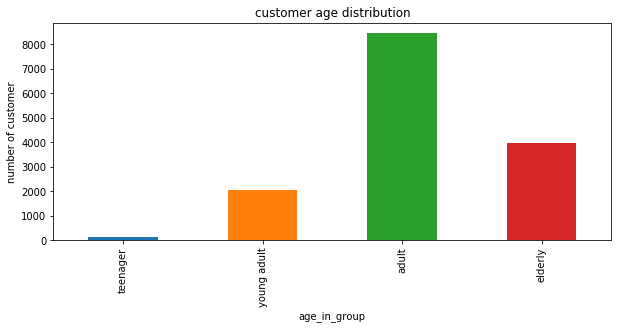

In [23]:
profile['age_in_group'].value_counts().sort_index(ascending=True).plot.bar(figsize=(10,4), fontsize=10);
plt.xlabel('age_in_group')
plt.ylabel('number of customer')
plt.title('customer age distribution');

In [24]:
profile = pd.concat([profile, pd.get_dummies(profile['age_in_group'], prefix='age', prefix_sep='_')], axis =1)

In [25]:
profile.drop(['age', 'age_in_group'], axis =1, inplace = True)


In [26]:
profile['member_duration_days'] = (datetime.today().date() - pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.date).dt.days

In [27]:
profile.drop(['became_member_on'], axis = 1, inplace = True)


In [28]:
profile['income_range'] = pd.cut(profile['income'], bins = range(30000, 140000, 10000), right = False, labels= ['30ks','40ks', '50ks', '60ks', '70ks','80ks', '90ks',\
                                            '100ks', '110ks', '120ks'])
profile = pd.concat([profile, pd.get_dummies(profile['income_range'], prefix = 'income', prefix_sep ='_')], axis = 1)


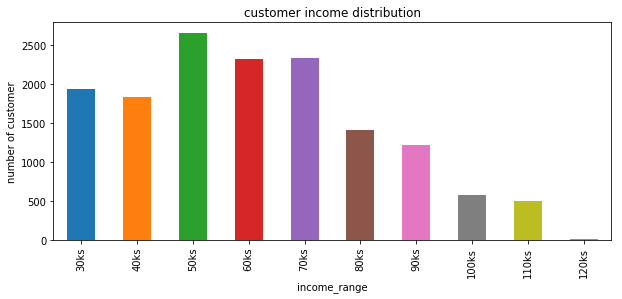

In [29]:
profile['income_range'].value_counts().sort_index(ascending=True).plot.bar(figsize=(10,4), fontsize=10);
plt.xlabel('income_range')
plt.ylabel('number of customer')
plt.title('customer income distribution');

In [30]:
profile.drop('income', axis =1, inplace = True)
profile.head()

,gender,customer_id,age_teenager,age_young adult,age_adult,age_elderly,member_duration_days,income_range,income_30ks,income_40ks,income_50ks,income_60ks,income_70ks,income_80ks,income_90ks,income_100ks,income_110ks,income_120ks
1,F,0610b486422d4921ae7d2bf64640c50b,0,0,1,0,1255,110ks,0,0,0,0,0,0,0,0,1,0
3,F,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,1,1322,100ks,0,0,0,0,0,0,0,1,0,0
5,M,e2127556f4f64592b11af22de27a7932,0,0,0,1,970,70ks,0,0,0,0,1,0,0,0,0,0
8,M,389bc3fa690240e798340f5a15918d5c,0,0,1,0,1046,50ks,0,0,1,0,0,0,0,0,0,0
12,M,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,1136,50ks,0,0,1,0,0,0,0,0,0,0


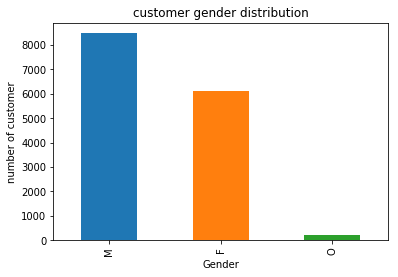

In [31]:
profile['gender'].value_counts().plot.bar(figsize = [6, 4], fontsize =10);
plt.xlabel('Gender')
plt.ylabel('number of customer')
plt.title('customer gender distribution');

In [32]:
profile = pd.concat([profile, pd.get_dummies(profile['gender'])], axis =1)
profile.drop('gender', axis =1)
profile.head()

,gender,customer_id,age_teenager,age_young adult,age_adult,age_elderly,member_duration_days,income_range,income_30ks,income_40ks,...,income_60ks,income_70ks,income_80ks,income_90ks,income_100ks,income_110ks,income_120ks,F,M,O
1,F,0610b486422d4921ae7d2bf64640c50b,0,0,1,0,1255,110ks,0,0,...,0,0,0,0,0,1,0,1,0,0
3,F,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,1,1322,100ks,0,0,...,0,0,0,0,1,0,0,1,0,0
5,M,e2127556f4f64592b11af22de27a7932,0,0,0,1,970,70ks,0,0,...,0,1,0,0,0,0,0,0,1,0
8,M,389bc3fa690240e798340f5a15918d5c,0,0,1,0,1046,50ks,0,0,...,0,0,0,0,0,0,0,0,1,0
12,M,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,1136,50ks,0,0,...,0,0,0,0,0,0,0,0,1,0


# Transcript 

In [33]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [34]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [35]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In this dataframe, first get rid of all the customer age 118. 

In [36]:
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)

In [37]:
transcript=transcript[~transcript['customer_id'].isin(customer_118)]
transcript.shape

(272762, 4)

In [38]:
transcript.head()
transcript[transcript['customer_id'].isin(customer_118)].count()

event          0
customer_id    0
time           0
value          0
dtype: int64

Hence, all the cusomter with age 118 have been removed from the trancript dataframe

In [39]:
transcript.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [40]:
transaction_df = transcript[transcript['event'] == 'transaction']
transaction_df.head()

,event,customer_id,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [41]:
offer_df = transcript[~(transcript['event'] == 'transaction')]
offer_df[offer_df['event'] == 'offer completed'].head()

,event,customer_id,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [42]:
offer_df.shape[0]

148805

In [43]:
transaction_df.shape[0]

123957

In [44]:
transaction_df['amount'] = transaction_df['value'].apply(lambda x: x['amount'])
transaction_df.drop(['event', 'value'], axis =1, inplace = True)
transaction_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [45]:
## this function is to peal the offer_id from the original value in the dataframe. It handles the 
def get_offer_id(x):
    for key, values in x.items():
        if key in ['offer id', 'offer_id']:
            return values

In [46]:
offer_df['offer_id'] = offer_df['value'].apply(get_offer_id)
offer_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,event,customer_id,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [47]:
offer_df.offer_id.isnull().sum()
## it shows that all the value and offer_id has been transformed into the new dataframe.

0

In [48]:
offer_df.drop(['value'], axis =1, inplace=True)
offer_df.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,event,customer_id,time,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [49]:
offer_df = pd.concat([offer_df, pd.get_dummies(offer_df['event'])], axis = 1)
offer_df.drop('event', axis =1, inplace = True)
offer_df.head()

,customer_id,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [50]:
offer_df[offer_df['customer_id'] =='78afa995795e4d85b5d9ceeca43f5fef']

,customer_id,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
15561,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1
47583,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
53176,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,1,0
85291,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,0,0,1
150598,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,0,1,0
163375,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1
201572,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
218394,78afa995795e4d85b5d9ceeca43f5fef,510,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
218395,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0


In [51]:
temp = offer_df[offer_df['customer_id'] =='78afa995795e4d85b5d9ceeca43f5fef'] [offer_df['offer_id'] == '9b98b8c7a33c4b65b9aebfe6a799e6d9']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [52]:
portfolio_res

,difficulty,duration,offer_id,reward,email,mobile,social,web,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0


In [53]:
## initialize the master data
## All the customers and offers needs to be iterated to check whether the customer is responding to an offer in the valid time
response_data = [] 
customer_id = offer_df.customer_id.unique().tolist()
offer_id    = offer_df.offer_id.unique().tolist()

# iterate over all the cusomters
for cid in customer_id:
    c_profile = profile[profile['customer_id'] == cid]
    c_offers = offer_df[offer_df['customer_id'] == cid]
    c_transaction = transaction_df[transaction_df['customer_id'] == cid]
    
    offer_received  = c_offers[c_offers['offer received'] == 1]
    offer_viewed    = c_offers[c_offers['offer viewed'] == 1]
    offer_completed = c_offers[c_offers['offer completed'] == 1]
    ## now iterate over the offers received by the customer
    temp = []
    for oid in offer_received['offer_id'].values.tolist():
        duration = portfolio_res.loc[portfolio_res['offer_id'] ==oid].duration.values[0]
        offer_rec_time = offer_received[offer_received['offer_id']==oid].time.values[0]
        offer_end_time = offer_rec_time + duration
        
        ## boolean array indicating whether the offer is viewed within the time period
        off_viewed_intime = np.logical_and(offer_viewed['time'] >= offer_rec_time, offer_viewed['time'] <= offer_end_time)
        
        ## differentiate the bogo, discount offers from the informational offer
        if portfolio_res[portfolio_res['offer_id'] == oid]['bogo'].values[0] ==1 or portfolio_res[portfolio_res['offer_id'] == oid]['discount'].values[0] ==1:
            offer_comp = np.logical_and(offer_completed['time'] >= offer_rec_time, offer_completed['time'] <= offer_end_time)
        
            ## customer transaction amount needs to be greater than the difficulty
            c_tran = c_transaction[np.logical_and(c_transaction['time'] >= offer_rec_time, c_transaction['time'] <= offer_end_time)]
            
            ## boolean array to determine whether the customer has responseded to an bogo or discounted offer
            
            c_res = np.logical_and((off_viewed_intime.sum()>=1 and offer_comp.sum()>=1), c_tran['amount'].sum() >=portfolio_res[portfolio_res['offer_id'] ==oid].difficulty.values[0])
        
        ## for the infomrational offer, determine whether a customer made a transaction in the time period
        else:
            c_tran_l = np.logical_and(c_transaction['time'] >= offer_rec_time, c_transaction['time'] <= offer_end_time)
            
            c_res = np.logical_and(c_tran_l.sum()>=1, off_viewed_intime.sum()>=1)
            
            c_tran = c_transaction[np.logical_and(c_transaction['time'] >= offer_rec_time, c_transaction['time'] <= offer_end_time)]
            
        
        customer_rec = {'customer_response': int(c_res),'time': offer_rec_time,'total_amount': c_tran['amount'].sum()}
        customer_rec.update(profile[profile['customer_id'] == cid].squeeze().to_dict())
        customer_rec.update(portfolio_res[portfolio_res['offer_id'] == oid].squeeze().to_dict())
        
        temp.append(customer_rec)
    
    response_data.extend(temp)
            

In [54]:
response_data_df = pd.DataFrame(response_data)
response_data_order = ['customer_id', 'offer_id', 'time']

In [55]:
## reorder the columns 
portfolio_list = portfolio_res.columns.tolist()
portfolio_list.remove('offer_id')
profile_list = profile.columns.tolist()
profile_list.remove('customer_id')
response_data_order.extend(portfolio_list)
response_data_order.extend(profile_list)
response_data_order.extend(['total_amount', 'customer_response'])
response_data_df = response_data_df.reindex(response_data_order, axis =1)

In [56]:
response_data_df.head()

,customer_id,offer_id,time,difficulty,duration,reward,email,mobile,social,web,...,income_80ks,income_90ks,income_100ks,income_110ks,income_120ks,F,M,O,total_amount,customer_response
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,168,5,1,1,0,1,...,0,0,1,0,0,1,0,0,37.67,1
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,0,72,0,1,1,1,0,...,0,0,1,0,0,1,0,0,49.39,1
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,10,168,10,1,1,1,0,...,0,0,1,0,0,1,0,0,48.28,1
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,5,120,5,1,1,1,1,...,0,0,1,0,0,1,0,0,48.28,1
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,10,168,2,1,1,0,1,...,0,0,0,0,0,0,1,0,0.00,0


In [57]:
## save the response dataframe to a csv file
#response_data_df.to_csv('response_data.csv', index = False)

In [58]:
#response_data_df.columns.tolist()

## calculate the success rate of each offer
#response_data_df = pd.read_csv('response_data.csv')
offer_success = response_data_df.groupby('offer_id')['customer_response'].count().reset_index()
success_rate = response_data_df.groupby('offer_id')['customer_response'].sum()/response_data_df.groupby('offer_id')['customer_response'].count()
offer_success['success_rate'] = success_rate.values
success_number =  response_data_df.groupby('offer_id')['customer_response'].sum()
offer_success['success_number'] = success_number.values
offer_success.rename(columns = {'customer_response': 'offer count'}, inplace = True)
offer_type_df = portfolio.drop(['channels','difficulty', 'duration', 'reward'], axis =1)
offer_success = offer_success.merge(offer_type_df, on = 'offer_id')

In [59]:
offertype_rate = offer_success.groupby('offer_type')['offer count', 'success_number'].sum().reset_index()
offertype_rate['success_rate'] = offertype_rate['success_number'].values/offertype_rate['offer count'].values

In [60]:
offertype_rate

,offer_type,offer count,success_number,success_rate
0,bogo,26537,14009,0.527904
1,discount,26664,15763,0.591172
2,informational,13300,6082,0.457293


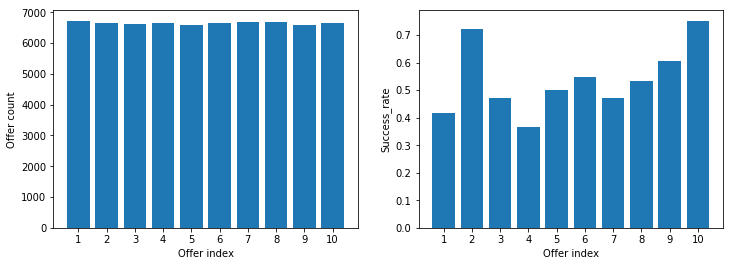

In [61]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

# plot the number of offers sent out
ax[0].bar(offer_success.index + 1, offer_success['offer count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('Offer index')
ax[0].set_ylabel('Offer count')

# plot that illustrate 
ax[1].bar(offer_success.index + 1, offer_success['success_rate'])
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('Offer index')
ax[1].set_ylabel('Success_rate');

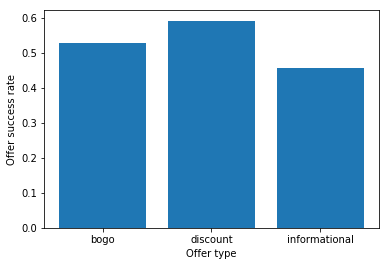

In [62]:
fig1, ax1 = plt.subplots()
ax1.bar(offertype_rate['offer_type'], offertype_rate['success_rate']);
ax1.set_xlabel('Offer type')
ax1.set_ylabel('Offer success rate');



# 2 Machine Learning Models

In [63]:
response_data_df.columns


Index(['customer_id', 'offer_id', 'time', 'difficulty', 'duration', 'reward',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       'gender', 'age_teenager', 'age_young adult', 'age_adult', 'age_elderly',
       'member_duration_days', 'income_range', 'income_30ks', 'income_40ks',
       'income_50ks', 'income_60ks', 'income_70ks', 'income_80ks',
       'income_90ks', 'income_100ks', 'income_110ks', 'income_120ks', 'F', 'M',
       'O', 'total_amount', 'customer_response'],
      dtype='object')

In [64]:
## drop the columns/features that should not be in the training
response_data_df.drop(columns = ['customer_id', 'offer_id', 'time', 'gender', 'total_amount'], inplace=True )


In [65]:
response_data_df.drop('income_range', axis =1, inplace = True)

In [66]:
## split the data into training data X and response data Y
X = response_data_df.drop('customer_response', axis =1)
y = response_data_df['customer_response']

In [67]:
X.columns

Index(['difficulty', 'duration', 'reward', 'email', 'mobile', 'social', 'web',
       'bogo', 'discount', 'informational', 'age_teenager', 'age_young adult',
       'age_adult', 'age_elderly', 'member_duration_days', 'income_30ks',
       'income_40ks', 'income_50ks', 'income_60ks', 'income_70ks',
       'income_80ks', 'income_90ks', 'income_100ks', 'income_110ks',
       'income_120ks', 'F', 'M', 'O'],
      dtype='object')

In [68]:
## perform minmax scaling on the numerical features
col_scale = ['difficulty', 'duration', 'reward', 'member_duration_days']
col_scale_df = X[col_scale]
scaler = MinMaxScaler()
feat_scale = pd.DataFrame(scaler.fit_transform(col_scale_df), columns = col_scale_df.columns, index = col_scale_df.index)
X.drop(columns = col_scale, inplace = True)
X = pd.concat([X, feat_scale], axis =1)

In [69]:
X.head()

,email,mobile,social,web,bogo,discount,informational,age_teenager,age_young adult,age_adult,...,income_100ks,income_110ks,income_120ks,F,M,O,difficulty,duration,reward,member_duration_days
0,1,1,0,1,1,0,0,0,0,0,...,1,0,0,1,0,0,0.25,0.571429,0.5,0.243006
1,1,1,1,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0.00,0.000000,0.0,0.243006
2,1,1,1,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0.50,0.571429,1.0,0.243006
3,1,1,1,1,1,0,0,0,0,0,...,1,0,0,1,0,0,0.25,0.285714,0.5,0.243006
4,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0.50,0.571429,0.2,0.049918


In [70]:
## split the training and testing data

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [71]:
##using gridsearch to find the best classifier
def train_classifier(clf, parameter_grid, X = X_train.values, y= y_train.squeeze().values):
    """
    Train classifier to its training data using GridSearchCV and report the performance
    
    INPUT:
    - clf: classifier
    - param_grid (dict): parameters used with GridSearchCV
    - X: features
    - y: label
            
    OUTPUT:
    - classifier: classifier fit the training data
    - performance score:  f1 associated with the clf
    
    """
    
    
    grid = GridSearchCV(estimator = clf, param_grid=parameter_grid, scoring = 'f1', cv =5)
    print('fitting {}'.format(clf.__class__.__name__))
    grid.fit(X, y)

    print('best f1 score: {}'.format(grid.best_score_, 3))
    print('-'*50)
    
    return grid.best_estimator_, grid.best_score_#, time_taken

    

In [72]:
clf_lg  = LogisticRegression(random_state=42)## initialize logistic regression
clf_rfc = RandomForestClassifier(random_state=42)## initialize random forest
clf_gbc = GradientBoostingClassifier(random_state=42) ## initialize gradient boosting
clf_abc = AdaBoostClassifier(random_state=42)  ## initialize Ada boosting
clf_nb  = GaussianNB()  ## initialize Naive bayes 
clf_dt  = DecisionTreeClassifier() # initialize decision tree 
clf_knn = KNeighborsClassifier() # initialize K nearest neighbors
clf_name = []
clf_f1   = []

clf_best_estimator = []

for clf in [clf_lg, clf_rfc, clf_gbc, clf_abc, clf_nb, clf_dt, clf_knn]:
    estimator, f1_score  = train_classifier(clf, {})
    clf_name.append(clf.__class__.__name__)
    clf_f1.append(f1_score)
    clf_best_estimator.append(estimator)
    
   


fitting LogisticRegression
best f1 score: 0.6746828800866458
--------------------------------------------------
fitting RandomForestClassifier
best f1 score: 0.6983992545827915
--------------------------------------------------
fitting GradientBoostingClassifier
best f1 score: 0.7018881847663414
--------------------------------------------------
fitting AdaBoostClassifier
best f1 score: 0.6975819163521484
--------------------------------------------------
fitting GaussianNB
best f1 score: 0.6241046601187146
--------------------------------------------------
fitting DecisionTreeClassifier
best f1 score: 0.7022028137075212
--------------------------------------------------
fitting KNeighborsClassifier
best f1 score: 0.6868916989909118
--------------------------------------------------


In [73]:
clf_df = pd.DataFrame()
clf_df['classifier'] = clf_name
clf_df['f1_score'] = clf_f1
clf_df['best_estimator'] = clf_best_estimator

In [74]:
clf_df

,classifier,f1_score,best_estimator
0,LogisticRegression,0.674683,"LogisticRegression(C=1.0, class_weight=None, d..."
1,RandomForestClassifier,0.698399,"(DecisionTreeClassifier(class_weight=None, cri..."
2,GradientBoostingClassifier,0.701888,([DecisionTreeRegressor(criterion='friedman_ms...
3,AdaBoostClassifier,0.697582,"(DecisionTreeClassifier(class_weight=None, cri..."
4,GaussianNB,0.624105,GaussianNB(priors=None)
5,DecisionTreeClassifier,0.702203,"DecisionTreeClassifier(class_weight=None, crit..."
6,KNeighborsClassifier,0.686892,"KNeighborsClassifier(algorithm='auto', leaf_si..."


Decision Tree Classifieryeids  the best result. Hence we will use grid search CV to further tune it. Moreover grid search cv will also be performed for random forest classifier since it generally has good performance. 

In [78]:
clf_df[clf_df['classifier'] == 'DecisionTreeClassifier']['best_estimator'].values

array([ DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')], dtype=object)

In [84]:
#parameter = {
#            "loss":["deviance"],
#            "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#            "min_samples_split": np.linspace(0.1, 0.5, 12),
#            "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#            "max_depth":[3,5,8],
#            "max_features":["log2","sqrt"],
#            "criterion": ["friedman_mse",  "mae"],
#            "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#            "n_estimators":[10]
#             }

parameter ={
            'criterion': ['entropy', 'gini'],
            'max_depth': [None, 3, 6, 10, 60],
            'min_samples_leaf': [0.1, 1, 2, 10]
           }

dt_best_est, dt_best_score = train_classifier(clf_dt, parameter)
dt_best_est

fitting DecisionTreeClassifier
best f1 score: 0.704147260665202
--------------------------------------------------


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=60,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [83]:
dt_best_score

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [85]:
parameter = {
            # Number of trees in random forest
              'n_estimators': [10, 50, 80, 100],
               # Maximum number of levels in tree
              'max_depth': [None],
               # Minimum number of samples required to split a node
              'min_samples_split': [2, 5, 10],
               # Minimum number of samples required at each leaf node
              'min_samples_leaf': [1, 2, 4]
}

rfc_best_est, rfc_best_score = train_classifier(clf_rfc, parameter)

fitting RandomForestClassifier
best f1 score: 0.7112838558615767
--------------------------------------------------


In [86]:
rfc_best_est

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

As shown, the tuned random forest classifier improve the f1 score to 0.71, which is better than that from the decision tree. Hence Random forest will be used.

In [91]:
## analyzing the feature importance
feature_imp = pd.DataFrame(rfc_best_est.feature_importances_, index=X_train.columns.tolist(),columns=['feature_importance']).reset_index()
feature_imp.rename(columns = {'index': 'feature'}, inplace = True)
feature_imp = feature_imp.sort_values(by = 'feature_importance', ascending = False).reset_index(drop = True)

In [92]:
feature_imp


,feature,feature_importance
0,member_duration_days,0.739174
1,social,0.037034
2,reward,0.019909
3,duration,0.017676
4,income_30ks,0.016801
5,difficulty,0.013328
6,income_40ks,0.013253
7,M,0.012330
8,age_adult,0.012065
9,F,0.011213


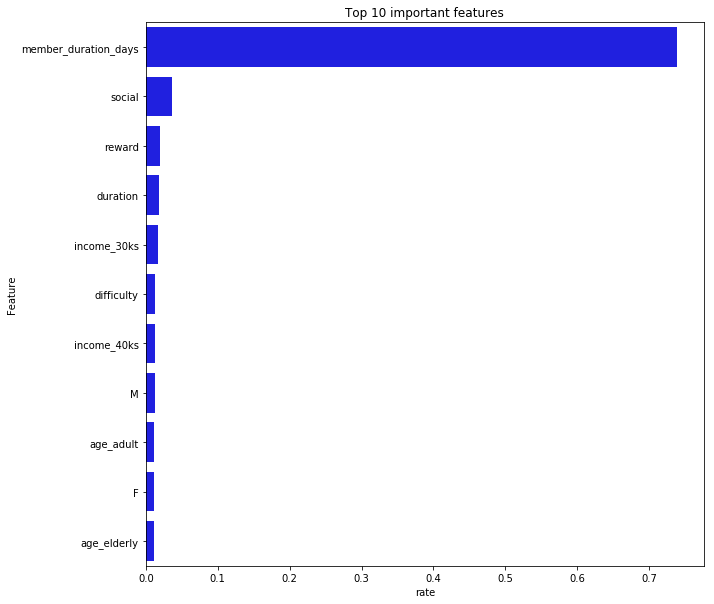

In [94]:
# Plot bar chart of features with their importance
fig, ax = plt.subplots(figsize=(10, 10),nrows=1,ncols=1)
sns.barplot(x=feature_imp.loc[0:10,'feature_importance'], y=feature_imp.loc[0:10,'feature'], color='b', data=feature_imp)
plt.xlabel('rate')
plt.ylabel('Feature')
plt.title('Top 10 important features')
plt.show()

# Observations <br>
The dominant feature in the offer is actually customer membership duration. It accounts for more than 70% of the importance. <br>
Customer responde better to offers sent via social media. <br>
In this data set, offers are more effective to customers in the low income brackets (30k, 40k). <br>
Offer labeld as reward is more attractive to customers.

# Validate against test data

In [103]:
y_pred = rfc_best_est.predict(X_test)

In [114]:
y_test = y_test.squeeze().values.tolist()

In [119]:
y_pred = y_pred.tolist()

In [137]:
## calculate the f1 score for this classfication 
f1_score(y_test,y_pred)

0.71835460676662388

In [141]:
## calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()

In [142]:
 
print('true negatives: {}'.format(tn/(tn+fp)))
print('false postives: {}'.format(fp/(tn+fp)))
print('false negatives: {}'.format(fn/(fn+tp)))
print('true postives: {}'.format(tp/(fn+tp)))


true negatives: 0.6743360504864581
false postives: 0.32566394951354194
false negatives: 0.28558758314855875
true postives: 0.7144124168514412


# Conclusion  

This jupyter workbook analyzes how customer responde to an offer sent out by Starbucks. First the data is preprocessed to combine the customer, offer and transcation information together. A response label 'customer_response' is created. It carefully considers the offer is success  by only counting the customer received, viewed and completed the offer and made a transaction within the offer valid period. 
Then the feature are engineered to be fit for machine learning algorithms. <br>
<br>
Finally GridSearch method is applied to a few classification algorithms and RandomForest classifier is chosen due to its best f1 score. The RandomForest classifier's parameters are further tuned using GridSearch. Its f1 score is around 0.7 for both training and testing data. By calculating the confusion matrix on the testing data, the recall score and precision score is about 0.7. It shows the selected RandomForest Classifier is fairly robust for this data set. And the accuracy of this model is about 70%. Moreover, it is determined that the most dominant feature in deciding an offer is successful is the customer membership duration, which accounts for more than 70% of total contribution. 


# Improvement  

In this project, the way the customer response label is created is very time confusing. It didn't take advantage the efficiency of Pandas. This is due to trickiness of qualifiying a successful customer respond. More efficient approach should be considered in generating this label. <br>
<br>
Some feature maybe classified differently. For instance, the income range and age are categorized into bins. A different way of categorization may help improve the f1 score of the model. Moreover, additional features could be helpful as well. <br>
<br>

This work can be improved by considering additional questions, like how different demographic reponde to different type of offers, etc.
